# ET-287 - Processamento de sinais usando redes neurais

_Aluno: Denys Derlian Carvalho Brito_

---

## Projeto Exame - Classificação de Desempenho em Criptografia Quântica com Redes Neurais Profundas

**Objetivo:** Desenvolver um classificador baseado em redes neurais profundas capaz de prever, a partir de variáveis heterogêneas de um ambiente de criptografia quântica, a classe de desempenho (“Ótimo” vs. “Subótimo”) com alta acurácia e boa capacidade de generalização.


No contexto da computação quântica, a criptografia quântica oferece novos paradigmas de segurança baseados em princípios de mecânica quântica. Sob essa perspectiva, a aplicação de técnicas de aprendizado de máquina tem sido explorada para otimizar e aprimorar o desempenho dos sistemas de criptografia quântica. Todavia, a complexidade inerente a esses sistemas, aliada à heterogeneidade dos dados gerados, impõe desafios significativos para a construção de modelos preditivos eficazes. Nesse cenário, propõe uma abordagem que foca na classificação da **performance da rede** de forma integrada, considerando não apenas os parâmetros quânticos e de segurança, mas também métricas de performance de rede, características de _big data_ e utilização de recursos computacionais, que em conjunto determinam a viabilidade prática dos sistema em cenários operacionais reais.

---


## 2. Criar um modelo baseline MLP usando TensorFlow/Keras

In [1]:
# Importart bibliotecas a partir do módulo config
from modules.config import *

/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-18 21:55:35.708334: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-18 21:55:36.169069: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-18 21:55:38.177368: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see sl

Num GPUs Available:  1


In [2]:
# Carregar os dados pre-processados
df_preprocessed = pd.read_csv("./data/preprocessed/df_preprocessed.csv")
X_numerical_df = pd.read_csv("./data/preprocessed/X_numerical_preprocessed.csv")
X_categorical_df = pd.read_csv("./data/preprocessed/X_categorical_preprocessed.csv")
y = pd.read_csv("./data/preprocessed/y_preprocessed.csv")


TARGET_VARIABLE = 'Performance_Target'
CATEGORICAL_COLUMNS = df_preprocessed.select_dtypes(include=['object', 'category']).columns.tolist()
NUMERICAL_COLUMNS = df_preprocessed.select_dtypes(include=['number']).columns.difference([TARGET_VARIABLE]).tolist()

In [3]:
# Criar um modelo baseline MLP usando TensorFlow/Keras
def create_baseline_mlp(input_dim, hidden_layers=None, activations=None, lr=1e-3, l2=1e-5, dropout=0.3):
    """
    Cria um modelo MLP configurável.
    
    Args:
        input_dim: Dimensão de entrada
        hidden_layers: Lista com número de neurônios em cada camada oculta. Default: [32, 16]
        activations: Lista com funções de ativação para cada camada. Default: ['relu', 'relu']
        lr: Learning rate
        l2: Fator de regularização L2
        dropout: Taxa de dropout (aplicada progressivamente)
    """
    if hidden_layers is None:
        hidden_layers = [32, 16]
    if activations is None:
        activations = ['relu'] * len(hidden_layers)
    
    if len(activations) != len(hidden_layers):
        raise ValueError("Número de ativações deve ser igual ao número de camadas ocultas")
    
    inp = layers.Input(shape=(input_dim,))
    x = inp
    
    # Criar camadas ocultas dinamicamente
    for i, (units, activation) in enumerate(zip(hidden_layers, activations)):
        x = layers.Dense(units, kernel_regularizer=regularizers.l2(l2))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        # Dropout progressivo: maior nas primeiras camadas
        dropout_rate = dropout * (1 - i / len(hidden_layers))
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate)(x)
    
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', 
                  metrics=[tf.keras.metrics.AUC(name='roc_auc'), 
                        tf.keras.metrics.AUC(name='pr_auc', curve='PR'),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall'), 
                           tf.keras.metrics.Accuracy(name='accuracy')])
    return model

In [4]:
# Visualizar arquitetura do modelo baseline (configuração padrão)
model_view = create_baseline_mlp(input_dim=len(NUMERICAL_COLUMNS))
model_view.summary()

I0000 00:00:1763513739.784802    3754 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,409 (5.50 KB)

 Trainable params: 1,313 (5.13 KB)

 Non-trainable params: 96 (384.00 B)

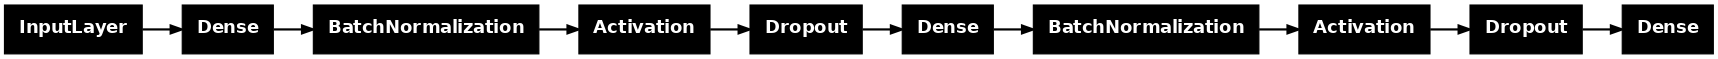

In [5]:
# Horizontal plot da arquitetura do modelo
model_view_plot = tf.keras.utils.plot_model(model_view, show_shapes=False, dpi=80, expand_nested=False, rankdir='LR')
model_view_plot

In [6]:
tf.keras.backend.clear_session()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

metrics = {
    'roc_auc': [], 'pr_auc': [], 'f1': [], 'precision': [], 'recall': [], 'accuracy': [], 'conf_mat': []
}

for fold, (train_idx, val_idx) in enumerate(skf.split(X_numerical_df, y), 1):
    print(f"\n--- Fold {fold} ---")
    
    # Separar dados
    X_num_train_raw = X_numerical_df.iloc[train_idx].values
    X_num_val_raw = X_numerical_df.iloc[val_idx].values
    y_train, y_val = y.iloc[train_idx].values.ravel(), y.iloc[val_idx].values.ravel()

    # Separar os dados categóricos
    X_cat_train = X_categorical_df.iloc[train_idx].values
    X_cat_val = X_categorical_df.iloc[val_idx].values

    # Fit scaler apenas no treino (evita data leakage)
    scaler_fold = MinMaxScaler()
    X_train = scaler_fold.fit_transform(X_num_train_raw)
    X_val = scaler_fold.transform(X_num_val_raw)

    # Concatenar dados numéricos escalados com categóricos
    X_train = np.hstack([X_train, X_cat_train])
    X_val = np.hstack([X_val, X_cat_val])
    
    # Calcular class weights por fold (não global)
    class_weights_values = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_fold = dict(enumerate(class_weights_values))
    print(f"Class weights para fold {fold}: {class_weight_fold}")

    # Modelo (usando configuração padrão: [32, 16] com 'relu')
    model = create_baseline_mlp(
        input_dim=X_train.shape[1],
        hidden_layers=[32, 16],
        activations=['relu', 'relu'],
        lr=1e-3,
        l2=1e-5,
        dropout=0.1
    )

    # Callbacks
    model_checkpoint = callbacks.ModelCheckpoint(
        filepath=f'./models/baseline_mlp_fold{fold}.keras',
        monitor='val_pr_auc',
        mode='max',
        save_best_only=True,
        verbose=0
    )
    es = callbacks.EarlyStopping(monitor='val_pr_auc', patience=10, mode='max', restore_best_weights=True, verbose=0)
    rl = callbacks.ReduceLROnPlateau(monitor='val_pr_auc', factor=0.5, patience=6, mode='max', verbose=0)

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        class_weight=class_weight_fold,
        callbacks=[es, rl, model_checkpoint],
        verbose=0
    )

    # Previsões e métricas
    y_pred_prob = model.predict(X_val).ravel()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    roc = roc_auc_score(y_val, y_pred_prob)
    pr = average_precision_score(y_val, y_pred_prob)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred, zero_division=0)
    acc = accuracy_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)

    print(f"ROC-AUC: {roc:.4f}  PR-AUC: {pr:.4f}  F1: {f1:.4f}  Prec: {prec:.4f}  Rec: {rec:.4f}  Acc: {acc:.4f}")
    print("Conf matrix:\n", cm)

    metrics['roc_auc'].append(roc)
    metrics['pr_auc'].append(pr)
    metrics['f1'].append(f1)
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['accuracy'].append(acc)
    metrics['conf_mat'].append(cm)


--- Fold 1 ---
Class weights para fold 1: {0: 0.5449591280653951, 1: 6.0606060606060606}


2025-11-07 20:13:41.692126: I external/local_xla/xla/service/service.cc:163] XLA service 0x7119dc0104a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-07 20:13:41.692151: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-11-07 20:13:41.728426: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-07 20:13:41.981734: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-11-07 20:13:41.981734: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
I0000 00:00:1762557223.669284  433479 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
I0000 00:00:1762557223.669284  433479 device_compiler.h:196] Compi

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
ROC-AUC: 0.9606  PR-AUC: 0.7312  F1: 0.6667  Prec: 0.6000  Rec: 0.7500  Acc: 0.9400
Conf matrix:
 [[176   8]
 [  4  12]]

--- Fold 2 ---
Class weights para fold 2: {0: 0.5449591280653951, 1: 6.0606060606060606}
ROC-AUC: 0.9606  PR-AUC: 0.7312  F1: 0.6667  Prec: 0.6000  Rec: 0.7500  Acc: 0.9400
Conf matrix:
 [[176   8]
 [  4  12]]

--- Fold 2 ---
Class weights para fold 2: {0: 0.5449591280653951, 1: 6.0606060606060606}
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
ROC-AUC: 0.9416  PR-AUC: 0.6319  F1: 0.5417  Prec: 0.4062  Rec: 0.8125  Acc: 0.8900
Conf matrix:
 [[165  19]
 [  3  13]]

--- Fold 3 ---
Class weights para fold 3: {0: 0.5449591280653951, 1: 6.0606060606060606}
ROC-AUC: 0.9416  PR-AUC: 0.6319  F1: 0.5417  Prec: 0.4062  Rec: 0.8125  Acc: 0.8900
Conf matrix:
 [[165  19]
 [  3  13]]

--- Fold 3 ---
Class weights para fold 3: {0: 0.5449591280653951, 1: 6.0606060606060606}
1/7 

In [7]:
# Encontrar o melhor threshold de decisão baseado na curva Precision-Recall
prec, rec, thresholds = precision_recall_curve(y_val, y_pred_prob)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
print(f"\nMelhor threshold baseado na curva PR: {best_threshold:.4f} com F1: {best_f1:.4f}")


Melhor threshold baseado na curva PR: 0.8715 com F1: 0.7586


In [8]:
# Resumo dos resultados:
def mean_std(lst):
    return np.mean(lst), np.std(lst)

print("\n=== Resumo final (5-fold) ===")
for k in ['roc_auc','pr_auc','f1','precision','recall','accuracy']:
    m, s = mean_std(metrics[k])
    print(f"{k}: {m:.4f} ± {s:.4f}")

# opcional: imprimir somatório das confusion matrices
total_cm = sum(metrics['conf_mat'])
print("Total confusion matrix (soma folds):\n", total_cm)


=== Resumo final (5-fold) ===
roc_auc: 0.9557 ± 0.0086
pr_auc: 0.7355 ± 0.0617
f1: 0.5883 ± 0.0460
precision: 0.4612 ± 0.0759
recall: 0.8397 ± 0.0658
accuracy: 0.9010 ± 0.0246
Total confusion matrix (soma folds):
 [[832  86]
 [ 13  69]]


---

## 4. Otimização de Hiperparâmetros com Optuna

Vamos usar o Optuna para encontrar a melhor combinação de:
- Número de camadas ocultas e neurônios
- Funções de ativação
- Learning rate
- Regularização L2
- Dropout

**Métrica de otimização:** PR-AUC (Precision-Recall Area Under Curve)
- PR-AUC é mais adequada para datasets desbalanceados
- Foca na performance na classe minoritária (Optimal)
- Mais sensível a melhorias na detecção da classe positiva

**Estratégia de Pruning:** MedianPruner
- Interrompe trials que apresentam resultados intermediários ruins
- Economiza tempo computacional focando em configurações promissoras
- Permite avaliar mais configurações no mesmo tempo
- Pruning ocorre durante o treinamento (por época) e entre folds do CV

In [9]:
# Função objetivo para o Optuna com Pruning
def objective(trial):
    # Hiperparâmetros a serem otimizados
    n_layers = trial.suggest_int('n_layers', 2, 5)
    hidden_layers = []
    activations = []
    
    for i in range(n_layers):
        n_units = trial.suggest_int(f'n_units_l{i}', 16, 128, step=16)
        activation = trial.suggest_categorical(f'activation_l{i}', ['relu', 'tanh', 'elu', 'selu'])
        hidden_layers.append(n_units)
        activations.append(activation)
    
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    l2 = trial.suggest_float('l2', 1e-6, 1e-3, log=True)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    
    # Usar 3-fold para otimização (mais rápido que 5-fold)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
    fold_pr_aucs = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_numerical_df, y), 1):
        # Separar dados
        X_num_train_raw = X_numerical_df.iloc[train_idx].values
        X_num_val_raw = X_numerical_df.iloc[val_idx].values
        y_train, y_val = y.iloc[train_idx].values.ravel(), y.iloc[val_idx].values.ravel()

        # Separar os dados categóricos
        X_cat_train = X_categorical_df.iloc[train_idx].values
        X_cat_val = X_categorical_df.iloc[val_idx].values

        # Fit scaler apenas no treino
        scaler_fold = MinMaxScaler()
        X_train = scaler_fold.fit_transform(X_num_train_raw)
        X_val = scaler_fold.transform(X_num_val_raw)

        # Concatenar dados numéricos escalados com categóricos
        X_train = np.hstack([X_train, X_cat_train])
        X_val = np.hstack([X_val, X_cat_val])
        
        # Calcular class weights por fold
        class_weights_values = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight_fold = dict(enumerate(class_weights_values))

        # Criar modelo com hiperparâmetros sugeridos
        model = create_baseline_mlp(
            input_dim=X_train.shape[1],
            hidden_layers=hidden_layers,
            activations=activations,
            lr=lr,
            l2=l2,
            dropout=dropout
        )

        # Callbacks (incluindo pruning do Optuna)
        model_checkpoint = callbacks.ModelCheckpoint(
            filepath=f'./models/optuna_trial{trial.number}_fold{fold}.keras',
            monitor='val_pr_auc',
            mode='max',
            save_best_only=True,
            verbose=0
        )
        pruning_callback = optuna.integration.TFKerasPruningCallback(trial, 'val_auc')
        es = callbacks.EarlyStopping(monitor='val_pr_auc', patience=10, mode='max', restore_best_weights=True, verbose=0)
        rl = callbacks.ReduceLROnPlateau(monitor='val_pr_auc', factor=0.5, patience=5, mode='max', verbose=0)

        # Treinar
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=batch_size,
            class_weight=class_weight_fold,
            callbacks=[es, rl, pruning_callback, model_checkpoint],
            verbose=0
        )

        # Avaliar usando PR-AUC
        y_pred_prob = model.predict(X_val, verbose=0).ravel()
        pr_auc = average_precision_score(y_val, y_pred_prob)
        fold_pr_aucs.append(pr_auc)
        
        # Reportar resultado intermediário para pruning entre folds
        # Permite interromper o trial se os primeiros folds já mostram resultados ruins
        intermediate_value = np.mean(fold_pr_aucs)
        trial.report(intermediate_value, fold)
        
        # Verificar se o trial deve ser podado
        if trial.should_prune():
            tf.keras.backend.clear_session()
            del model
            raise optuna.TrialPruned()
        
        # Limpar memória
        tf.keras.backend.clear_session()
        del model
    
    # Retornar média do PR-AUC nos 3 folds
    mean_pr_auc = np.mean(fold_pr_aucs)
    return mean_pr_auc

In [10]:
# Criar e executar o estudo Optuna com Pruning
print("Iniciando otimização de hiperparâmetros com Optuna...")
print("Usando MedianPruner para interromper trials não promissores")
print("Isso pode levar algum tempo...\n")

# MedianPruner: poda trials cujo valor intermediário é pior que a mediana dos trials anteriores
pruner = optuna.pruners.MedianPruner(
    n_startup_trials=5,  # Número de trials completos antes de começar a podar
    n_warmup_steps=1,    # Número de steps (folds) antes de começar a podar dentro de um trial
    interval_steps=1     # Verificar a cada fold se deve podar
)

study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_SEED),
    pruner=pruner,
    study_name='mlp_quantum_encryption'
)

# Executar otimização com 50 trials
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n=== Resultados da Otimização ===")
print(f"Melhor PR-AUC: {study.best_value:.4f}")
print(f"Trials completados: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
print(f"Trials podados: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
print(f"\nMelhores hiperparâmetros:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-07 20:14:51,569] A new study created in memory with name: mlp_quantum_encryption


Iniciando otimização de hiperparâmetros com Optuna...
Usando MedianPruner para interromper trials não promissores
Isso pode levar algum tempo...



  0%|          | 0/50 [00:00<?, ?it/s]/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation log

[I 2025-11-07 20:15:48,533] Trial 0 finished with value: 0.30792013728719964 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'activation_l0': 'relu', 'n_units_l1': 16, 'activation_l1': 'relu', 'n_units_l2': 128, 'activation_l2': 'relu', 'lr': 8.17949947521167e-05, 'l2': 3.752055855124284e-05, 'dropout': 0.2727780074568463, 'batch_size': 32}. Best is trial 0 with value: 0.30792013728719964.


2025-11-07 20:15:50.857999: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:15:50.858058: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:15:50.858070: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:15:50.858077: I external/l

[I 2025-11-07 20:16:34,872] Trial 1 finished with value: 0.7367843298529354 and parameters: {'n_layers': 3, 'n_units_l0': 48, 'activation_l0': 'tanh', 'n_units_l1': 80, 'activation_l1': 'tanh', 'n_units_l2': 128, 'activation_l2': 'relu', 'lr': 0.0011290133559092666, 'l2': 2.091498132903561e-05, 'dropout': 0.14881529393791154, 'batch_size': 64}. Best is trial 1 with value: 0.7367843298529354.


2025-11-07 20:16:37.174703: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:16:37.174754: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:16:37.174765: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:16:37.174774: I external/l

[I 2025-11-07 20:17:38,613] Trial 2 finished with value: 0.670054352478037 and parameters: {'n_layers': 3, 'n_units_l0': 96, 'activation_l0': 'elu', 'n_units_l1': 128, 'activation_l1': 'tanh', 'n_units_l2': 128, 'activation_l2': 'selu', 'lr': 0.00014656553886225324, 'l2': 6.516990611177181e-06, 'dropout': 0.43149500366077176, 'batch_size': 64}. Best is trial 1 with value: 0.7367843298529354.


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you se

[I 2025-11-07 20:19:35,738] Trial 3 finished with value: 0.33278246907118 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'activation_l0': 'tanh', 'n_units_l1': 16, 'activation_l1': 'relu', 'lr': 1.667761543019792e-05, 'l2': 1.1895896737553539e-05, 'dropout': 0.1463476238100519, 'batch_size': 16}. Best is trial 1 with value: 0.7367843298529354.


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you se

[I 2025-11-07 20:20:21,128] Trial 4 finished with value: 0.8140832404733134 and parameters: {'n_layers': 2, 'n_units_l0': 48, 'activation_l0': 'selu', 'n_units_l1': 64, 'activation_l1': 'elu', 'lr': 0.002055424552015075, 'l2': 3.0296104428212496e-05, 'dropout': 0.3090931317527976, 'batch_size': 16}. Best is trial 4 with value: 0.8140832404733134.


2025-11-07 20:20:23.037521: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:20:23.037604: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:20:23.533798: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1736', 16 bytes spill stores, 16 bytes spill loads

2025-11-07 20:20:23.629301: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

[I 2025-11-07 20:20:32,754] Trial 5 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 4. Best value: 0.814083:  14%|█▍        | 7/50 [06:06<29:20, 40.93s/it]

[I 2025-11-07 20:20:57,605] Trial 6 pruned. 


2025-11-07 20:21:01.185145: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:21:01.185230: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:21:01.185277: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:21:01.185285: I external/l

[I 2025-11-07 20:21:35,070] Trial 7 pruned. 


2025-11-07 20:21:37.345439: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:21:37.345569: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:21:37.970617: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2420', 12 bytes spill stores, 12 bytes spill loads

2025-11-07 20:21:37.984825: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

[I 2025-11-07 20:22:21,386] Trial 8 finished with value: 0.7748779524896344 and parameters: {'n_layers': 3, 'n_units_l0': 32, 'activation_l0': 'elu', 'n_units_l1': 80, 'activation_l1': 'selu', 'n_units_l2': 64, 'activation_l2': 'relu', 'lr': 0.0059440281134109305, 'l2': 0.00042856634196503465, 'dropout': 0.20317665108606225, 'batch_size': 32}. Best is trial 4 with value: 0.8140832404733134.


2025-11-07 20:22:24.220727: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:22:24.220789: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:22:24.220801: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:22:24.220808: I external/l

[I 2025-11-07 20:22:41,850] Trial 9 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you se

[I 2025-11-07 20:23:56,607] Trial 10 finished with value: 0.7983633366553446 and parameters: {'n_layers': 5, 'n_units_l0': 64, 'activation_l0': 'selu', 'n_units_l1': 96, 'activation_l1': 'elu', 'n_units_l2': 16, 'activation_l2': 'elu', 'n_units_l3': 16, 'activation_l3': 'relu', 'n_units_l4': 128, 'activation_l4': 'elu', 'lr': 0.001097236014829981, 'l2': 1.6537304047673328e-06, 'dropout': 0.48970762482140096, 'batch_size': 16}. Best is trial 4 with value: 0.8140832404733134.


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 4. Best value: 0.814083:  24%|██▍       | 12/50 [09:27<25:13, 39.84s/it]

[I 2025-11-07 20:24:19,282] Trial 11 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you se

[I 2025-11-07 20:25:43,791] Trial 12 finished with value: 0.7542312996587285 and parameters: {'n_layers': 4, 'n_units_l0': 16, 'activation_l0': 'selu', 'n_units_l1': 96, 'activation_l1': 'elu', 'n_units_l2': 48, 'activation_l2': 'elu', 'n_units_l3': 16, 'activation_l3': 'relu', 'lr': 0.0011509546479317348, 'l2': 1.4344482856794777e-06, 'dropout': 0.47850090837668996, 'batch_size': 16}. Best is trial 4 with value: 0.8140832404733134.


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you se

[I 2025-11-07 20:26:43,103] Trial 13 finished with value: 0.7790580840786104 and parameters: {'n_layers': 4, 'n_units_l0': 80, 'activation_l0': 'selu', 'n_units_l1': 48, 'activation_l1': 'elu', 'n_units_l2': 48, 'activation_l2': 'tanh', 'n_units_l3': 64, 'activation_l3': 'tanh', 'lr': 0.007289355188779403, 'l2': 3.717776848691308e-06, 'dropout': 0.336536409266572, 'batch_size': 16}. Best is trial 4 with value: 0.8140832404733134.


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
2025-11-07 20:27:05.551323: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:27:05.551323: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/t

[I 2025-11-07 20:27:26,393] Trial 14 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 4. Best value: 0.814083:  32%|███▏      | 16/50 [12:58<24:28, 43.18s/it]

[I 2025-11-07 20:27:50,058] Trial 15 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 4. Best value: 0.814083:  34%|███▍      | 17/50 [13:51<25:20, 46.07s/it]

[I 2025-11-07 20:28:42,856] Trial 16 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you se

[I 2025-11-07 20:29:28,377] Trial 17 finished with value: 0.750349432456308 and parameters: {'n_layers': 2, 'n_units_l0': 16, 'activation_l0': 'selu', 'n_units_l1': 96, 'activation_l1': 'elu', 'lr': 0.0025242789449318034, 'l2': 1.0634793259454468e-05, 'dropout': 0.3090476698440828, 'batch_size': 16}. Best is trial 4 with value: 0.8140832404733134.


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 4. Best value: 0.814083:  38%|███▊      | 19/50 [14:56<19:35, 37.93s/it]

[I 2025-11-07 20:29:47,727] Trial 18 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 4. Best value: 0.814083:  40%|████      | 20/50 [15:34<19:02, 38.08s/it]

[I 2025-11-07 20:30:26,145] Trial 19 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 4. Best value: 0.814083:  42%|████▏     | 21/50 [16:00<16:39, 34.48s/it]

[I 2025-11-07 20:30:52,232] Trial 20 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 4. Best value: 0.814083:  44%|████▍     | 22/50 [16:18<13:48, 29.60s/it]

[I 2025-11-07 20:31:10,446] Trial 21 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 4. Best value: 0.814083:  46%|████▌     | 23/50 [16:37<11:53, 26.42s/it]

[I 2025-11-07 20:31:29,459] Trial 22 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 4. Best value: 0.814083:  48%|████▊     | 24/50 [17:01<11:07, 25.66s/it]

[I 2025-11-07 20:31:53,338] Trial 23 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you se

[I 2025-11-07 20:32:51,154] Trial 24 finished with value: 0.793445294088583 and parameters: {'n_layers': 5, 'n_units_l0': 48, 'activation_l0': 'selu', 'n_units_l1': 32, 'activation_l1': 'elu', 'n_units_l2': 16, 'activation_l2': 'selu', 'n_units_l3': 64, 'activation_l3': 'relu', 'n_units_l4': 16, 'activation_l4': 'elu', 'lr': 0.008889230265877311, 'l2': 2.2738336114286616e-06, 'dropout': 0.3358717714145689, 'batch_size': 16}. Best is trial 4 with value: 0.8140832404733134.


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 4. Best value: 0.814083:  52%|█████▏    | 26/50 [18:25<13:02, 32.60s/it]

[I 2025-11-07 20:33:17,425] Trial 25 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
2025-11-07 20:33:46.799343: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:33:46.799343: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
Best trial: 4. Best value: 0.814083:  54%|█████▍    | 27/50 [18:57<12:23, 32.32s/it]

[I 2025-11-07 20:33:49,095] Trial 26 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 4. Best value: 0.814083:  56%|█████▌    | 28/50 [19:22<11:02, 30.10s/it]

[I 2025-11-07 20:34:14,010] Trial 27 pruned. 


2025-11-07 20:34:17.301181: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:34:17.775383: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3752', 8 bytes spill stores, 8 bytes spill loads

2025-11-07 20:34:17.807327: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3752', 44 bytes spill stores, 44 bytes spill loads

2025-11-07 20:34:17.909141: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3752', 288 byt

[I 2025-11-07 20:34:36,027] Trial 28 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 4. Best value: 0.814083:  60%|██████    | 30/50 [19:59<07:58, 23.92s/it]

[I 2025-11-07 20:34:51,188] Trial 29 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 4. Best value: 0.814083:  62%|██████▏   | 31/50 [20:28<08:01, 25.33s/it]

[I 2025-11-07 20:35:19,812] Trial 30 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you se

[I 2025-11-07 20:36:11,041] Trial 31 finished with value: 0.7681006440118594 and parameters: {'n_layers': 4, 'n_units_l0': 80, 'activation_l0': 'selu', 'n_units_l1': 48, 'activation_l1': 'elu', 'n_units_l2': 48, 'activation_l2': 'tanh', 'n_units_l3': 64, 'activation_l3': 'tanh', 'lr': 0.009859242494096676, 'l2': 3.3490238063831077e-06, 'dropout': 0.33870074381696813, 'batch_size': 16}. Best is trial 4 with value: 0.8140832404733134.


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 4. Best value: 0.814083:  66%|██████▌   | 33/50 [21:41<08:24, 29.68s/it]

[I 2025-11-07 20:36:32,753] Trial 32 pruned. 


2025-11-07 20:36:44.471287: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_236', 4 bytes spill stores, 4 bytes spill loads

/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
2025-11-07 20:36:51.176493: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representat

[I 2025-11-07 20:36:53,623] Trial 33 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 4. Best value: 0.814083:  70%|███████   | 35/50 [22:23<06:22, 25.49s/it]

[I 2025-11-07 20:37:15,499] Trial 34 pruned. 


2025-11-07 20:37:18.774835: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:37:18.774905: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:37:18.774915: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:37:18.774935: I external/l

[I 2025-11-07 20:37:37,731] Trial 35 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 4. Best value: 0.814083:  74%|███████▍  | 37/50 [23:01<04:42, 21.70s/it]

[I 2025-11-07 20:37:52,878] Trial 36 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 4. Best value: 0.814083:  76%|███████▌  | 38/50 [23:15<03:53, 19.45s/it]

[I 2025-11-07 20:38:07,060] Trial 37 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 4. Best value: 0.814083:  78%|███████▊  | 39/50 [23:42<03:58, 21.67s/it]

[I 2025-11-07 20:38:33,913] Trial 38 pruned. 


2025-11-07 20:38:40.673148: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3612', 4 bytes spill stores, 4 bytes spill loads

/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 4. Best value: 0.814083:  80%|████████  | 40/50 [23:59<03:22, 20.21s/it]

[I 2025-11-07 20:38:50,735] Trial 39 pruned. 


2025-11-07 20:38:52.580697: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 20:38:52.757479: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1044', 8 bytes spill stores, 8 bytes spill loads

2025-11-07 20:38:52.890177: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1751', 8 bytes spill stores, 8 bytes spill loads

2025-11-07 20:38:52.890177: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1751', 8 bytes s

[I 2025-11-07 20:39:05,064] Trial 40 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 4. Best value: 0.814083:  84%|████████▍ | 42/50 [24:26<02:15, 16.92s/it]

[I 2025-11-07 20:39:18,415] Trial 41 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you se

[I 2025-11-07 20:39:53,648] Trial 42 finished with value: 0.8278334434467683 and parameters: {'n_layers': 2, 'n_units_l0': 16, 'activation_l0': 'selu', 'n_units_l1': 96, 'activation_l1': 'selu', 'lr': 0.006857424104552869, 'l2': 0.00038179780253350245, 'dropout': 0.1361537489982792, 'batch_size': 32}. Best is trial 42 with value: 0.8278334434467683.


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you se

[I 2025-11-07 20:40:33,316] Trial 43 finished with value: 0.8197098948443795 and parameters: {'n_layers': 2, 'n_units_l0': 16, 'activation_l0': 'selu', 'n_units_l1': 128, 'activation_l1': 'selu', 'lr': 0.003724223916254971, 'l2': 5.4443102924374725e-05, 'dropout': 0.10952653985076158, 'batch_size': 32}. Best is trial 42 with value: 0.8278334434467683.


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you se

[I 2025-11-07 20:41:09,765] Trial 44 finished with value: 0.8304759819711492 and parameters: {'n_layers': 2, 'n_units_l0': 16, 'activation_l0': 'selu', 'n_units_l1': 128, 'activation_l1': 'selu', 'lr': 0.0036222894549584298, 'l2': 5.121959502529069e-05, 'dropout': 0.10052997054918425, 'batch_size': 32}. Best is trial 44 with value: 0.8304759819711492.


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 44. Best value: 0.830476:  92%|█████████▏| 46/50 [26:32<01:41, 25.46s/it]

[I 2025-11-07 20:41:24,063] Trial 45 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you se

[I 2025-11-07 20:42:00,100] Trial 46 finished with value: 0.8311240430532431 and parameters: {'n_layers': 2, 'n_units_l0': 16, 'activation_l0': 'selu', 'n_units_l1': 128, 'activation_l1': 'selu', 'lr': 0.0034595605448207614, 'l2': 4.428592452938914e-05, 'dropout': 0.13184031512846445, 'batch_size': 32}. Best is trial 46 with value: 0.8311240430532431.


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 46. Best value: 0.831124:  96%|█████████▌| 48/50 [27:21<00:47, 23.92s/it]

[I 2025-11-07 20:42:13,031] Trial 47 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
Best trial: 46. Best value: 0.831124:  98%|█████████▊| 49/50 [27:35<00:20, 20.89s/it]

[I 2025-11-07 20:42:26,842] Trial 48 pruned. 


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna_integration/tfkeras/tfkeras.py:53: UserWarning: The metric 'val_auc' is not in the evaluation logs for pruning. Please make sure you se

[I 2025-11-07 20:43:02,807] Trial 49 finished with value: 0.8014635327793845 and parameters: {'n_layers': 2, 'n_units_l0': 16, 'activation_l0': 'selu', 'n_units_l1': 128, 'activation_l1': 'selu', 'lr': 0.005809237413467125, 'l2': 0.00016777771443133552, 'dropout': 0.13873128901605344, 'batch_size': 32}. Best is trial 46 with value: 0.8311240430532431.

=== Resultados da Otimização ===
Melhor PR-AUC: 0.8311
Trials completados: 17
Trials podados: 33

Melhores hiperparâmetros:
  n_layers: 2
  n_units_l0: 16
  activation_l0: selu
  n_units_l1: 128
  activation_l1: selu
  lr: 0.0034595605448207614
  l2: 4.428592452938914e-05
  dropout: 0.13184031512846445
  batch_size: 32


In [11]:
# Visualizar histórico de otimização
fig_history = plot_optimization_history(study)
fig_history.update_layout(title="Histórico de Otimização - PR-AUC ao longo dos trials")
fig_history.show()

In [12]:
# Visualizar importância dos hiperparâmetros
fig_importance = plot_param_importances(study)
fig_importance.update_layout(title="Importância dos Hiperparâmetros")
fig_importance.show()

In [13]:
# Reconstruir a arquitetura otimizada
best_params = study.best_params

# Extrair configuração das camadas
n_layers = best_params['n_layers']
best_hidden_layers = [best_params[f'n_units_l{i}'] for i in range(n_layers)]
best_activations = [best_params[f'activation_l{i}'] for i in range(n_layers)]

print("=== Arquitetura Otimizada ===")
print(f"Número de camadas: {n_layers}")
for i, (units, act) in enumerate(zip(best_hidden_layers, best_activations)):
    print(f"  Camada {i+1}: {units} neurônios, ativação={act}")
print(f"\nLearning rate: {best_params['lr']:.6f}")
print(f"L2 regularization: {best_params['l2']:.6f}")
print(f"Dropout: {best_params['dropout']:.3f}")
print(f"Batch size: {best_params['batch_size']}")

=== Arquitetura Otimizada ===
Número de camadas: 2
  Camada 1: 16 neurônios, ativação=selu
  Camada 2: 128 neurônios, ativação=selu

Learning rate: 0.003460
L2 regularization: 0.000044
Dropout: 0.132
Batch size: 32


In [14]:
# Avaliar modelo otimizado com 5-fold CV
print("=== Avaliação do Modelo Otimizado com 5-fold CV ===\n")

tf.keras.backend.clear_session()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

optimized_metrics = {
    'roc_auc': [], 'pr_auc': [], 'f1': [], 'precision': [], 'recall': [], 'accuracy': [], 'conf_mat': []
}

for fold, (train_idx, val_idx) in enumerate(skf.split(X_numerical_df, y), 1):
    print(f"--- Fold {fold} ---")
    
    # Separar dados
    X_num_train_raw = X_numerical_df.iloc[train_idx].values
    X_num_val_raw = X_numerical_df.iloc[val_idx].values
    y_train, y_val = y.iloc[train_idx].values.ravel(), y.iloc[val_idx].values.ravel()

    # Separar os dados categóricos
    X_cat_train = X_categorical_df.iloc[train_idx].values
    X_cat_val = X_categorical_df.iloc[val_idx].values

    # Fit scaler apenas no treino
    scaler_fold = MinMaxScaler()
    X_train = scaler_fold.fit_transform(X_num_train_raw)
    X_val = scaler_fold.transform(X_num_val_raw)

    # Concatenar dados numéricos escalados com categóricos
    X_train = np.hstack([X_train, X_cat_train])
    X_val = np.hstack([X_val, X_cat_val])
    
    # Calcular class weights por fold
    class_weights_values = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_fold = dict(enumerate(class_weights_values))

    # Modelo otimizado
    model = create_baseline_mlp(
        input_dim=X_train.shape[1],
        hidden_layers=best_hidden_layers,
        activations=best_activations,
        lr=best_params['lr'],
        l2=best_params['l2'],
        dropout=best_params['dropout']
    )

    # Callbacks
    model_checkpoint = callbacks.ModelCheckpoint(
        filepath=f'./models/optimized_mlp_fold{fold}.keras',
        monitor='val_pr_auc',
        mode='max',
        save_best_only=True,
        verbose=0
    )
    es = callbacks.EarlyStopping(monitor='val_pr_auc', patience=10, mode='max', restore_best_weights=True, verbose=0)
    rl = callbacks.ReduceLROnPlateau(monitor='val_pr_auc', factor=0.5, patience=6, mode='max', verbose=0)

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=best_params['batch_size'],
        class_weight=class_weight_fold,
        callbacks=[es, rl, model_checkpoint],
        verbose=0
    )

    # Previsões e métricas
    y_pred_prob = model.predict(X_val, verbose=0).ravel()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    roc = roc_auc_score(y_val, y_pred_prob)
    pr = average_precision_score(y_val, y_pred_prob)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred, zero_division=0)
    acc = accuracy_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)

    print(f"ROC-AUC: {roc:.4f}  PR-AUC: {pr:.4f}  F1: {f1:.4f}  Prec: {prec:.4f}  Rec: {rec:.4f}  Acc: {acc:.4f}")
    print("Conf matrix:\n", cm)

    optimized_metrics['roc_auc'].append(roc)
    optimized_metrics['pr_auc'].append(pr)
    optimized_metrics['f1'].append(f1)
    optimized_metrics['precision'].append(prec)
    optimized_metrics['recall'].append(rec)
    optimized_metrics['accuracy'].append(acc)
    optimized_metrics['conf_mat'].append(cm)
    
    tf.keras.backend.clear_session()

print("\n=== Resumo Final do Modelo Otimizado (5-fold CV) ===")
for k in ['roc_auc','pr_auc','f1','precision','recall','accuracy']:
    m, s = np.mean(optimized_metrics[k]), np.std(optimized_metrics[k])
    print(f"{k}: {m:.4f} ± {s:.4f}")

total_cm_optimized = sum(optimized_metrics['conf_mat'])
print("\nTotal confusion matrix (soma dos 5 folds):\n", total_cm_optimized)

=== Avaliação do Modelo Otimizado com 5-fold CV ===

--- Fold 1 ---
--- Fold 1 ---
ROC-AUC: 0.9664  PR-AUC: 0.7087  F1: 0.6667  Prec: 0.5385  Rec: 0.8750  Acc: 0.9300
Conf matrix:
 [[172  12]
 [  2  14]]
ROC-AUC: 0.9664  PR-AUC: 0.7087  F1: 0.6667  Prec: 0.5385  Rec: 0.8750  Acc: 0.9300
Conf matrix:
 [[172  12]
 [  2  14]]
--- Fold 2 ---
--- Fold 2 ---
ROC-AUC: 0.9725  PR-AUC: 0.8181  F1: 0.5581  Prec: 0.4444  Rec: 0.7500  Acc: 0.9050
Conf matrix:
 [[169  15]
 [  4  12]]
ROC-AUC: 0.9725  PR-AUC: 0.8181  F1: 0.5581  Prec: 0.4444  Rec: 0.7500  Acc: 0.9050
Conf matrix:
 [[169  15]
 [  4  12]]
--- Fold 3 ---
--- Fold 3 ---
ROC-AUC: 0.9742  PR-AUC: 0.7693  F1: 0.6667  Prec: 0.5652  Rec: 0.8125  Acc: 0.9350
Conf matrix:
 [[174  10]
 [  3  13]]
ROC-AUC: 0.9742  PR-AUC: 0.7693  F1: 0.6667  Prec: 0.5652  Rec: 0.8125  Acc: 0.9350
Conf matrix:
 [[174  10]
 [  3  13]]
--- Fold 4 ---
--- Fold 4 ---
ROC-AUC: 0.9624  PR-AUC: 0.8641  F1: 0.6977  Prec: 0.5769  Rec: 0.8824  Acc: 0.9350
Conf matrix:
 [[1

In [ ]:
# Encontrar o fold com melhor PR-AUC
best_fold_idx = np.argmax(optimized_metrics['pr_auc'])
best_fold_number = int(best_fold_idx + 1)

print(f"\n=== Melhor Modelo Otimizado ===")
print(f"Fold: {best_fold_number}")
print(f"PR-AUC: {optimized_metrics['pr_auc'][best_fold_idx]:.4f}")
print(f"ROC-AUC: {optimized_metrics['roc_auc'][best_fold_idx]:.4f}")
print(f"F1-Score: {optimized_metrics['f1'][best_fold_idx]:.4f}")
print(f"Precision: {optimized_metrics['precision'][best_fold_idx]:.4f}")
print(f"Recall: {optimized_metrics['recall'][best_fold_idx]:.4f}")
print(f"Accuracy: {optimized_metrics['accuracy'][best_fold_idx]:.4f}")

# Copiar o melhor modelo para um arquivo final

best_model_path = f'./models/optimized_mlp_fold{best_fold_number}.keras'
final_model_path = './models/best_optimized_mlp.keras'
shutil.copy(best_model_path, final_model_path)
print(f"\nMelhor modelo salvo em: {final_model_path}")

# Salvar informações do melhor modelo em JSON
best_model_info = {
    'model_type': 'MLP_Optimized',
    'best_fold': best_fold_number,
    'architecture': {
        'hidden_layers': best_hidden_layers,
        'activations': best_activations,
        'input_dim': X_train.shape[1]
    },
    'hyperparameters': {
        'lr': float(best_params['lr']),
        'l2': float(best_params['l2']),
        'dropout': float(best_params['dropout']),
        'batch_size': int(best_params['batch_size'])
    },
    'metrics': {
        'pr_auc': float(optimized_metrics['pr_auc'][best_fold_idx]),
        'roc_auc': float(optimized_metrics['roc_auc'][best_fold_idx]),
        'f1_score': float(optimized_metrics['f1'][best_fold_idx]),
        'precision': float(optimized_metrics['precision'][best_fold_idx]),
        'recall': float(optimized_metrics['recall'][best_fold_idx]),
        'accuracy': float(optimized_metrics['accuracy'][best_fold_idx])
    },
    'cv_metrics_mean': {
        'pr_auc': float(np.mean(optimized_metrics['pr_auc'])),
        'roc_auc': float(np.mean(optimized_metrics['roc_auc'])),
        'f1_score': float(np.mean(optimized_metrics['f1'])),
        'precision': float(np.mean(optimized_metrics['precision'])),
        'recall': float(np.mean(optimized_metrics['recall'])),
        'accuracy': float(np.mean(optimized_metrics['accuracy']))
    },
    'cv_metrics_std': {
        'pr_auc': float(np.std(optimized_metrics['pr_auc'])),
        'roc_auc': float(np.std(optimized_metrics['roc_auc'])),
        'f1_score': float(np.std(optimized_metrics['f1'])),
        'precision': float(np.std(optimized_metrics['precision'])),
        'recall': float(np.std(optimized_metrics['recall'])),
        'accuracy': float(np.std(optimized_metrics['accuracy']))
    }
}

with open('./models/best_optimized_mlp_info.json', 'w') as f:
    json.dump(best_model_info, f, indent=4)

print("Informações do modelo salvas em: ./models/best_optimized_mlp_info.json")


=== Melhor Modelo Otimizado ===
Fold: 4
PR-AUC: 0.8641
ROC-AUC: 0.9624
F1-Score: 0.6977
Precision: 0.5769
Recall: 0.8824
Accuracy: 0.9350

Melhor modelo salvo em: ./models/best_optimized_mlp.keras
Informações do modelo salvas em: ./models/best_optimized_mlp_info.json


In [ ]:
models_dir = Path('./models')
print("=== Modelos Salvos ===\n")

# Listar modelos baseline
baseline_models = sorted(models_dir.glob('baseline_mlp_*.keras'))
print("Modelos Baseline:")
for model_path in baseline_models:
    size_mb = model_path.stat().st_size / (1024 * 1024)
    print(f"  - {model_path.name} ({size_mb:.2f} MB)")

# Listar modelos otimizados
print("\nModelos Otimizados (5-fold CV):")
optimized_models = sorted(models_dir.glob('optimized_mlp_fold*.keras'))
for model_path in optimized_models:
    size_mb = model_path.stat().st_size / (1024 * 1024)
    print(f"  - {model_path.name} ({size_mb:.2f} MB)")

# Modelo final
print("\nModelo Final:")
final_model = models_dir / 'best_optimized_mlp.keras'
if final_model.exists():
    size_mb = final_model.stat().st_size / (1024 * 1024)
    print(f"  - {final_model.name} ({size_mb:.2f} MB)")
    print(f"  - Informações: best_optimized_mlp_info.json")

# Contar modelos do Optuna (apenas para referência, podem ser muitos)
optuna_models = list(models_dir.glob('optuna_trial*.keras'))
if optuna_models:
    print(f"\nModelos de trials do Optuna: {len(optuna_models)} arquivos")
    total_size = sum(m.stat().st_size for m in optuna_models) / (1024 * 1024)
    print(f"  Espaço total: {total_size:.2f} MB")

=== Modelos Salvos ===

Modelos Baseline:
  - baseline_mlp_fold1.keras (0.07 MB)
  - baseline_mlp_fold2.keras (0.07 MB)
  - baseline_mlp_fold3.keras (0.07 MB)
  - baseline_mlp_fold4.keras (0.07 MB)
  - baseline_mlp_fold5.keras (0.07 MB)

Modelos Otimizados (5-fold CV):
  - optimized_mlp_fold1.keras (0.08 MB)
  - optimized_mlp_fold2.keras (0.08 MB)
  - optimized_mlp_fold3.keras (0.08 MB)
  - optimized_mlp_fold4.keras (0.08 MB)
  - optimized_mlp_fold5.keras (0.08 MB)

Modelo Final:
  - best_optimized_mlp.keras (0.08 MB)
  - Informações: best_optimized_mlp_info.json

Modelos de trials do Optuna: 101 arquivos
  Espaço total: 18.96 MB


---

## 5. Carregar e Usar o Melhor Modelo

Exemplo de como carregar o melhor modelo salvo e fazer predições:

In [17]:
# Carregar o melhor modelo
best_model = tf.keras.models.load_model('./models/best_optimized_mlp.keras')

# Carregar informações do modelo
with open('./models/best_optimized_mlp_info.json', 'r') as f:
    model_info = json.load(f)

print("=== Informações do Melhor Modelo ===")
print(f"Tipo: {model_info['model_type']}")
print(f"Fold: {model_info['best_fold']}")
print(f"\nArquitetura:")
print(f"  Camadas ocultas: {model_info['architecture']['hidden_layers']}")
print(f"  Ativações: {model_info['architecture']['activations']}")
print(f"\nHiperparâmetros:")
for key, value in model_info['hyperparameters'].items():
    print(f"  {key}: {value}")
print(f"\nMétricas (melhor fold):")
for key, value in model_info['metrics'].items():
    print(f"  {key}: {value:.4f}")
print(f"\nMétricas CV (média ± std):")
for key in model_info['cv_metrics_mean'].keys():
    mean_val = model_info['cv_metrics_mean'][key]
    std_val = model_info['cv_metrics_std'][key]
    print(f"  {key}: {mean_val:.4f} ± {std_val:.4f}")

# Exemplo de como fazer predições com novos dados
print("\n=== Exemplo de Predição ===")
print("Para fazer predições com novos dados:")
print("1. Preprocessar os dados da mesma forma (scaling, encoding)")
print("2. Usar: predictions = best_model.predict(X_new)")
print("3. Threshold: predictions_binary = (predictions >= 0.5).astype(int)")

=== Informações do Melhor Modelo ===
Tipo: MLP_Optimized
Fold: 4

Arquitetura:
  Camadas ocultas: [16, 128]
  Ativações: ['selu', 'selu']

Hiperparâmetros:
  lr: 0.0034595605448207614
  l2: 4.428592452938914e-05
  dropout: 0.13184031512846445
  batch_size: 32

Métricas (melhor fold):
  pr_auc: 0.8641
  roc_auc: 0.9624
  f1_score: 0.6977
  precision: 0.5769
  recall: 0.8824
  accuracy: 0.9350

Métricas CV (média ± std):
  pr_auc: 0.7974 ± 0.0537
  roc_auc: 0.9699 ± 0.0047
  f1_score: 0.6547 ± 0.0497
  precision: 0.5488 ± 0.0583
  recall: 0.8169 ± 0.0546
  accuracy: 0.9290 ± 0.0124

=== Exemplo de Predição ===
Para fazer predições com novos dados:
1. Preprocessar os dados da mesma forma (scaling, encoding)
2. Usar: predictions = best_model.predict(X_new)
3. Threshold: predictions_binary = (predictions >= 0.5).astype(int)


=== Comparação: Baseline vs Otimizado ===

  Métrica  Baseline (Mean)  Baseline (Std)  Otimizado (Mean)  Otimizado (Std)  Melhoria (%)
  ROC-AUC         0.955737        0.008580          0.969880         0.004699          1.48
   PR-AUC         0.735472        0.061747          0.797366         0.053658          8.42
 F1-Score         0.588323        0.045976          0.654672         0.049655         11.28
Precision         0.461207        0.075866          0.548819         0.058296         19.00
   Recall         0.839706        0.065791          0.816912         0.054551         -2.71
 Accuracy         0.901000        0.024576          0.929000         0.012410          3.11
  Métrica  Baseline (Mean)  Baseline (Std)  Otimizado (Mean)  Otimizado (Std)  Melhoria (%)
  ROC-AUC         0.955737        0.008580          0.969880         0.004699          1.48
   PR-AUC         0.735472        0.061747          0.797366         0.053658          8.42
 F1-Score         0.588323        0.0

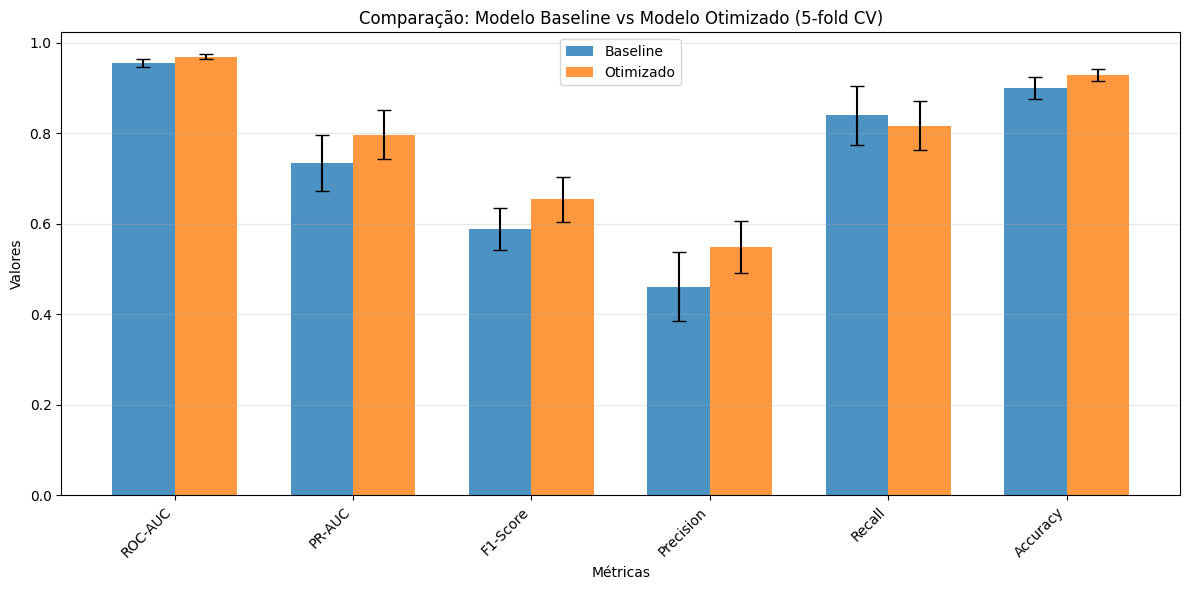

In [18]:
# Comparação entre modelo baseline e modelo otimizado
print("=== Comparação: Baseline vs Otimizado ===\n")

comparison_df = pd.DataFrame({
    'Métrica': ['ROC-AUC', 'PR-AUC', 'F1-Score', 'Precision', 'Recall', 'Accuracy'],
    'Baseline (Mean)': [
        np.mean(metrics['roc_auc']),
        np.mean(metrics['pr_auc']),
        np.mean(metrics['f1']),
        np.mean(metrics['precision']),
        np.mean(metrics['recall']),
        np.mean(metrics['accuracy'])
    ],
    'Baseline (Std)': [
        np.std(metrics['roc_auc']),
        np.std(metrics['pr_auc']),
        np.std(metrics['f1']),
        np.std(metrics['precision']),
        np.std(metrics['recall']),
        np.std(metrics['accuracy'])
    ],
    'Otimizado (Mean)': [
        np.mean(optimized_metrics['roc_auc']),
        np.mean(optimized_metrics['pr_auc']),
        np.mean(optimized_metrics['f1']),
        np.mean(optimized_metrics['precision']),
        np.mean(optimized_metrics['recall']),
        np.mean(optimized_metrics['accuracy'])
    ],
    'Otimizado (Std)': [
        np.std(optimized_metrics['roc_auc']),
        np.std(optimized_metrics['pr_auc']),
        np.std(optimized_metrics['f1']),
        np.std(optimized_metrics['precision']),
        np.std(optimized_metrics['recall']),
        np.std(optimized_metrics['accuracy'])
    ]
})

comparison_df['Melhoria (%)'] = ((comparison_df['Otimizado (Mean)'] - comparison_df['Baseline (Mean)']) / comparison_df['Baseline (Mean)'] * 100).round(2)

print(comparison_df.to_string(index=False))

# Visualizar comparação
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df['Métrica']))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Baseline (Mean)'], width, 
               yerr=comparison_df['Baseline (Std)'], label='Baseline', capsize=5, alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['Otimizado (Mean)'], width,
               yerr=comparison_df['Otimizado (Std)'], label='Otimizado', capsize=5, alpha=0.8)

ax.set_xlabel('Métricas')
ax.set_ylabel('Valores')
ax.set_title('Comparação: Modelo Baseline vs Modelo Otimizado (5-fold CV)')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Métrica'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()